In [ ]:
! pip install pandas numpy pillow scikit-learn tqdm decord
! pip3 install torch torchvision torchaudio torchcodec --index-url https://download.pytorch.org/whl/cu126

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu126


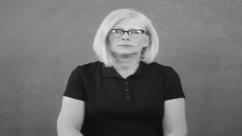

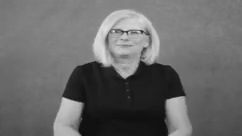

video_id    7070
label       book
offset        87
length        43
Name: 3, dtype: object


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader
from IPython import display
import torch
import time
from PIL import Image
from torchcodec.decoders import VideoDecoder
from torchcodec.samplers import clips_at_random_indices
import torch.nn.utils.rnn as rnn_utils
# import decord
DEVICE = 'cuda'

torch.set_default_dtype(torch.float16)

class VideoDataset(Dataset):
    def __init__(self, annotations_file, vid_file, device):
        self.annotations = pd.read_csv(annotations_file)
        labels = self.annotations['label']
        self.label_map = {c: i for i, c in enumerate(set(labels))}
        self.labels = torch.tensor([self.label_map[s] for s in labels]).to(device)
        self.cap = VideoDecoder(vid_file, device='cpu', num_ffmpeg_threads=0, seek_mode='approximate')
        self.device = device

    def __len__(self):
        return len(self.annotations)
    
    def get_clips(self, clips: list[range]):
        # Clip off the start & end frames because sometimes invalid frames are selected
        frames = self.cap.get_frames_at([i for clip in clips for i in clip])
        frames = frames.data[:, 0:1, :, :] / 255
        
        batch = []
        i = 0
        for r in clips:
            l = len(r)
            clip = frames[i: l]
            batch.append(clip)
            
        return batch
        # frames = [self.cap.get_frames_in_range(r.start, r.stop).data[:, 0:1, :, :] / 255 for r in clips]
        # return frames
    
    def get_vid(self, idx):
        offset, length, _ = self[idx]
        return self.get_clips([range(offset + 1, offset + length - 1)])[0]

    def __getitem__(self, idx):
        row = self.annotations.loc[idx]
        return row['offset'], row['length'], self.labels[idx]
    #self.get_clip(row['offset'], row['length']), self.labels[idx]

def show_frame(frame):
    frame.cpu()
    frame *= 255
    display.display(Image.fromarray(frame.numpy().astype(np.uint8)))

def play_video(vid):
    vid = ds.get_vid(vid)[0].cpu()
    for frame in vid[:,0,:,:]:
        display.clear_output(wait=True)
        show_frame(frame)
        time.sleep(1/15)
    
def get_first_last(vid):
    frame_start = vid[0][0].cpu()
    frame_end = vid[-1][0].cpu()
    
    show_frame(frame_start)
    show_frame(frame_end)

def stats(i):
    get_first_last(ds.get_vid(i))
    print(ds.annotations.loc[i])
        
ds = VideoDataset('labels.csv', 'wlasl_downsampled.mp4', DEVICE)

stats(3)

In [211]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn.utils.rnn as rnn_utils

TEST_SIZE = 0.8
BATCH_SIZE = 64
SEED = 10

train_i, test_i = train_test_split(
    range(len(ds)),
    stratify=ds.annotations['label'],
    test_size=TEST_SIZE,
    random_state=SEED
    )

torch.manual_seed(SEED)

train_split = Subset(ds, train_i)
test_split = Subset(ds, test_i)

def collate(batch):
    batch.sort(key=lambda x: x[0], reverse=True)

    videos = ds.get_clips([range(o + 1, o + l - 1) for o, l, _ in batch])

    batch.sort(key=lambda x: x[1], reverse=True)
    
    offsets, lengths, labels = zip(*batch)

    padded_videos = rnn_utils.pad_sequence(videos).to(DEVICE)

    lengths = [l - 2 for l in lengths]
    
    return padded_videos, lengths, torch.stack(labels)

train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, collate_fn=collate)

In [212]:
from torch import nn


class TransformerModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_2d = nn.Sequential(
            nn.Flatten(0, 1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 1, 5),
            )
        
        self.layers_1d = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1680, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
        )

        self.rnn = nn.GRU(100, 100)

        self.output = nn.Sequential(
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 1910),
            nn.Softmax(dim=1)
        )


    def forward(self, inp, lengths):
        x = inp
        frames, batch, channels, h, w = x.shape
        x = self.layers_2d(x)
        x = self.layers_1d(x)
        x = x.view(frames, batch, -1)
        x = rnn_utils.pack_padded_sequence(x, lengths, enforce_sorted=False)
        x, h = self.rnn(x)
        x = h[0, :, :]
        output = self.output(x)
        
        return output

model = TransformerModule()
model.to(DEVICE)

def print_hook(module, args, output):
    inp = args[0]
    if isinstance(inp, torch.Tensor):
        inp = inp.shape
    elif isinstance(inp, rnn_utils.PackedSequence) :
        inp = inp.data.shape
    
    if isinstance(output, tuple):
        output = output[0]
    outp = output.shape
    name = type(module).__name__
    print(f'{name}: {inp}, {outp}')

handles = []

for child in model.children():
    if child.children():
        for child_ in child.children():
            handles.append(child_.register_forward_hook(print_hook))
    else:
        handles.append(child.register_forward_hook(print_hook))

sample, lengths, _ = next(iter(train_batches))

result = model(sample, lengths)

print(result.shape)

for handle in handles:
    handle.remove()

Flatten: torch.Size([52, 64, 1, 136, 242]), torch.Size([3328, 1, 136, 242])
MaxPool2d: torch.Size([3328, 1, 136, 242]), torch.Size([3328, 1, 34, 60])
BatchNorm2d: torch.Size([3328, 1, 34, 60]), torch.Size([3328, 1, 34, 60])
Conv2d: torch.Size([3328, 1, 34, 60]), torch.Size([3328, 1, 30, 56])
Flatten: torch.Size([3328, 1, 30, 56]), torch.Size([3328, 1680])
Linear: torch.Size([3328, 1680]), torch.Size([3328, 100])
ReLU: torch.Size([3328, 100]), torch.Size([3328, 100])
BatchNorm1d: torch.Size([3328, 100]), torch.Size([3328, 100])
BatchNorm1d: torch.Size([64, 100]), torch.Size([64, 100])
Linear: torch.Size([64, 100]), torch.Size([64, 100])
ReLU: torch.Size([64, 100]), torch.Size([64, 100])
BatchNorm1d: torch.Size([64, 100]), torch.Size([64, 100])
Linear: torch.Size([64, 100]), torch.Size([64, 1910])
Softmax: torch.Size([64, 1910]), torch.Size([64, 1910])
torch.Size([64, 1910])


In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torch import profiler

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 1

with profiler.profile(
    activities=[
        profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,
    ]
) as prof:
    def a():
        with profiler.record_function("model_forward"):
            model.train()
            for epoch in range(num_epochs):
                running_loss = 0.0
                i = 0
                for inputs, lengths, annotations in tqdm(train_batches, smoothing=0.8):
                    i += 1
                    if i > 5:
                        return
                    optimizer.zero_grad()
                    outputs = model(inputs, lengths)
                    loss = criterion(outputs, annotations)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_batches)}")

    a()

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, lengths, annotations in tqdm(test_batches, smoothing=0.8):
#         outputs = model(inputs, lengths)
#         _, predicted = torch.max(outputs.data, 1)
#         total += annotations.size(0)
#         correct += (predicted == annotations).sum().item()

# print(f"Accuracy: {100 * correct / total}%")

 11%|█         | 4/37 [00:29<04:03,  7.38s/it]